In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/데이콘/제주도 교통량 예측

/content/drive/MyDrive/데이콘/제주도 교통량 예측


### 라이브러리

In [ ]:
# 필요 라이브러리 import
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import gc
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 적용
plt.rc('font', family='NanumBarunGothic')

# 깔금한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


### Custom Color 적용하기

Light mode palette
Dark mode palette


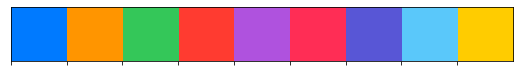

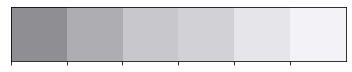

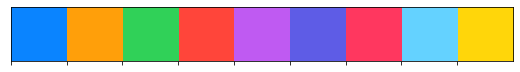

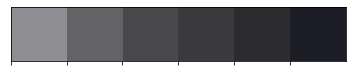

In [ ]:
# custom 색상 적용(apple color)
from cycler import cycler

raw_light_palette = [
    (0, 122, 255), # Blue
    (255, 149, 0), # Orange
    (52, 199, 89), # Green
    (255, 59, 48), # Red
    (175, 82, 222),# Purple
    (255, 45, 85), # Pink
    (88, 86, 214), # Indigo
    (90, 200, 250),# Teal
    (255, 204, 0)  # Yellow
]

raw_dark_palette = [
    (10, 132, 255), # Blue
    (255, 159, 10), # Orange
    (48, 209, 88),  # Green
    (255, 69, 58),  # Red
    (191, 90, 242), # Purple
    (94, 92, 230),  # Indigo
    (255, 55, 95),  # Pink
    (100, 210, 255),# Teal
    (255, 214, 10)  # Yellow
]

raw_gray_light_palette = [
    (142, 142, 147),# Gray
    (174, 174, 178),# Gray (2)
    (199, 199, 204),# Gray (3)
    (209, 209, 214),# Gray (4)
    (229, 229, 234),# Gray (5)
    (242, 242, 247),# Gray (6)
]

raw_gray_dark_palette = [
    (142, 142, 147),# Gray
    (99, 99, 102),  # Gray (2)
    (72, 72, 74),   # Gray (3)
    (58, 58, 60),   # Gray (4)
    (44, 44, 46),   # Gray (5)
    (28, 28, 39),   # Gray (6)
]

light_palette = np.array(raw_light_palette)/255
dark_palette = np.array(raw_dark_palette)/255
gray_light_palette = np.array(raw_gray_light_palette)/255
gray_dark_palette = np.array(raw_gray_dark_palette)/255

# apple에서는 light 버전, dar 버전이 있다.
print('Light mode palette')
sns.palplot(light_palette)
sns.palplot(gray_light_palette)

print('Dark mode palette')
sns.palplot(dark_palette)
sns.palplot(gray_dark_palette)

In [ ]:
# dark mode 적용
# cmap 수정
mpl.rcParams['axes.prop_cycle'] = cycler('color',dark_palette)

# 전체적인 배경색 수정
mpl.rcParams['figure.facecolor']  = gray_dark_palette[-2] # 배경 색
mpl.rcParams['figure.edgecolor']  = gray_dark_palette[-2] # 테두리 색
mpl.rcParams['axes.facecolor'] =  gray_dark_palette[-2]

# 사용되는 텍스트 색상 흰색으로 수정
white_color = gray_light_palette[-2]
mpl.rcParams['text.color'] = white_color
mpl.rcParams['axes.labelcolor'] = white_color
mpl.rcParams['axes.edgecolor'] = white_color
mpl.rcParams['xtick.color'] = white_color
mpl.rcParams['ytick.color'] = white_color

# 해상도 조정
mpl.rcParams['figure.dpi'] = 100

# ax의 우측과 상단 지우기
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

### 데이터 불러오기

In [ ]:
# 메모리 효율을 위한 parquet 형식 저장
# def csv_to_parquet(csv_path,save_name):
#     df = pd.read_csv(csv_path)
#     df.to_parquet(f'./{save_name}.parquet')
#     del df
#     gc.collect()
#     print(save_name,"Done")
    
# csv_to_parquet('./data/train.csv','train')
# csv_to_parquet('./data/test.csv','test')

In [ ]:
# 각 데이터 불러오기
# 데이콘 데이터
info = pd.read_csv("./data/data_info.csv")
train_data = pd.read_parquet("./train.parquet")
test_data = pd.read_parquet("./test.parquet")

# 기상청 제주 기상 데이터
weather1 = pd.read_csv("./data/2021 제주도 기상 데이터.csv",encoding='cp949')
weather2 = pd.read_csv("./data/2022 제주도 기상 데이터.csv",encoding='cp949')

In [ ]:
# 데이터 설명
info

,변수명,변수 설명
0,id,아이디
1,base_date,날짜
2,day_of_week,요일
3,base_hour,시간대
4,road_in_use,도로사용여부
5,lane_count,차로수
6,road_rating,도로등급
7,multi_linked,중용구간 여부
8,connect_code,연결로 코드
9,maximum_speed_limit,최고속도제한


In [ ]:
# train data 타입 확인
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     object 
 1   base_date              int64  
 2   day_of_week            object 
 3   base_hour              int64  
 4   lane_count             int64  
 5   road_rating            int64  
 6   road_name              object 
 7   multi_linked           int64  
 8   connect_code           int64  
 9   maximum_speed_limit    float64
 10  vehicle_restricted     float64
 11  weight_restricted      float64
 12  height_restricted      float64
 13  road_type              int64  
 14  start_node_name        object 
 15  start_latitude         float64
 16  start_longitude        float64
 17  start_turn_restricted  object 
 18  end_node_name          object 
 19  end_latitude           float64
 20  end_longitude          float64
 21  end_turn_restricted    object 
 22  target            

In [ ]:
# train data column별 결측치 확인
print(train_data.isnull().sum())

id                       0
base_date                0
day_of_week              0
base_hour                0
lane_count               0
road_rating              0
road_name                0
multi_linked             0
connect_code             0
maximum_speed_limit      0
vehicle_restricted       0
weight_restricted        0
height_restricted        0
road_type                0
start_node_name          0
start_latitude           0
start_longitude          0
start_turn_restricted    0
end_node_name            0
end_latitude             0
end_longitude            0
end_turn_restricted      0
target                   0
dtype: int64


In [ ]:
# test data 타입 확인
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291241 entries, 0 to 291240
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     291241 non-null  object 
 1   base_date              291241 non-null  int64  
 2   day_of_week            291241 non-null  object 
 3   base_hour              291241 non-null  int64  
 4   lane_count             291241 non-null  int64  
 5   road_rating            291241 non-null  int64  
 6   road_name              291241 non-null  object 
 7   multi_linked           291241 non-null  int64  
 8   connect_code           291241 non-null  int64  
 9   maximum_speed_limit    291241 non-null  float64
 10  vehicle_restricted     291241 non-null  float64
 11  weight_restricted      291241 non-null  float64
 12  height_restricted      291241 non-null  float64
 13  road_type              291241 non-null  int64  
 14  start_node_name        291241 non-nu

In [ ]:
# test_data 결측치 확인
print(test_data.isnull().sum())

id                       0
base_date                0
day_of_week              0
base_hour                0
lane_count               0
road_rating              0
road_name                0
multi_linked             0
connect_code             0
maximum_speed_limit      0
vehicle_restricted       0
weight_restricted        0
height_restricted        0
road_type                0
start_node_name          0
start_latitude           0
start_longitude          0
start_turn_restricted    0
end_node_name            0
end_latitude             0
end_longitude            0
end_turn_restricted      0
dtype: int64


### 날씨 데이터 전처리

In [ ]:
# print(weather1.info())
# print(weather2.info())

# 일별 기온, 강수량, 풍속, 적설량, 전운량 데이터프레임 생성
def day_weather(df):
  df = df.fillna(0)
  df = df.groupby("일시").mean()
  df['강수유무'] = df['일강수량(mm)'].apply(lambda x: 1 if x > 0 else 0)
  df['적설유무'] = df['일 최심신적설(cm)'].apply(lambda x: 1 if x > 0 else 0)
  df = df.drop(['지점','일강수량(mm)','안개 계속시간(hr)','일 최심신적설(cm)'],axis=1)
  df['base_date'] = df.index
  df = df.rename(columns = {'평균기온(°C)' : '평균기온', '평균 풍속(m/s)' : '평균풍속', '평균 전운량(1/10)' : '평균전운량'})
  return df

In [ ]:
w1 = day_weather(weather1)
w2 = day_weather(weather2)
weather = pd.concat([w1,w2],ignore_index=True)

In [ ]:
# 날씨 데이터와 조인을 위한 전처리 및 파생변수 생성
def preprocessing(df):
    df['base_date'] = df['base_date'].map(lambda x : str(x)[:4] + '-' + str(x)[4:6] + '-' + str(x)[6:])
    df['start_end_equal'] = df['start_node_name'] == df['end_node_name']
    df = df.astype({'base_date' : 'object'})
    total_df = pd.merge(df,weather,how='left',on='base_date')
    return total_df

train_data = preprocessing(train_data)
test_data = preprocessing(test_data)

In [ ]:
# 각 범주형 변수들 LabelEncoding
from sklearn.preprocessing import LabelEncoder
def encoding(df):
  str_col = ['day_of_week','start_turn_restricted','end_turn_restricted','road_name','start_end_equal']
  for i in str_col:
      le = LabelEncoder()
      le=le.fit(train_data[[i]])
      train_data[i]=le.transform(train_data[i])
      
      for label in np.unique(test_data[i]):
          if label not in le.classes_: 
              le.classes_ = np.append(le.classes_, label)
      test_data[i]=le.transform(test_data[i])
  return df

train_set = encoding(train_data)
test_set = encoding(test_data)

In [ ]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4701217 entries, 0 to 4701216
Data columns (total 29 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     object 
 1   base_date              object 
 2   day_of_week            int64  
 3   base_hour              int64  
 4   lane_count             int64  
 5   road_rating            int64  
 6   road_name              int64  
 7   multi_linked           int64  
 8   connect_code           int64  
 9   maximum_speed_limit    float64
 10  vehicle_restricted     float64
 11  weight_restricted      float64
 12  height_restricted      float64
 13  road_type              int64  
 14  start_node_name        object 
 15  start_latitude         float64
 16  start_longitude        float64
 17  start_turn_restricted  int64  
 18  end_node_name          object 
 19  end_latitude           float64
 20  end_longitude          float64
 21  end_turn_restricted    int64  
 22  target            

### EDA

In [ ]:
# 범주형 데이터 시각화
def obj_plot(column_name):
    if len(train_data[column_name].unique()) > 20:
        print(len(train_data[column_name].unique()))
    else:
        print(train_data[column_name].value_counts())
    
    
    fig, ax = plt.subplots(1,2,figsize=(12,7))
    sns.countplot(x=column_name,data=train_data,ax=ax[0])
    sns.kdeplot(x='target', data=train_data, ax=ax[1],fill=True,hue=column_name, 
            hue_order=sorted(train_data[column_name].unique()))
						#,multiple="layer"))
    plt.show()

0    684024
2    675583
1    674070
4    673632
5    669767
6    662498
3    661643
Name: day_of_week, dtype: int64


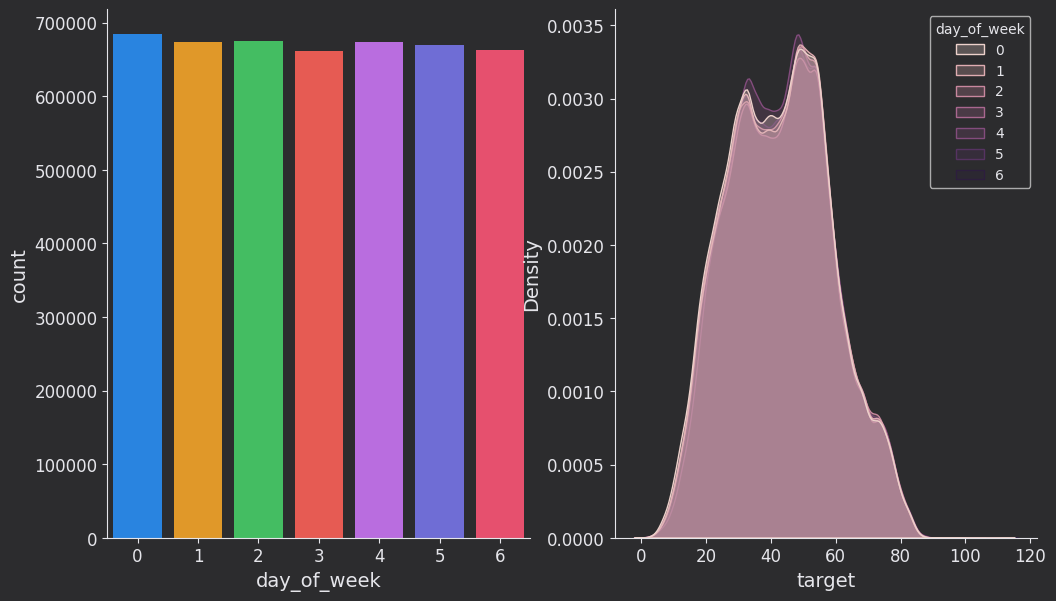

In [ ]:
# 요일
obj_plot("day_of_week")

61


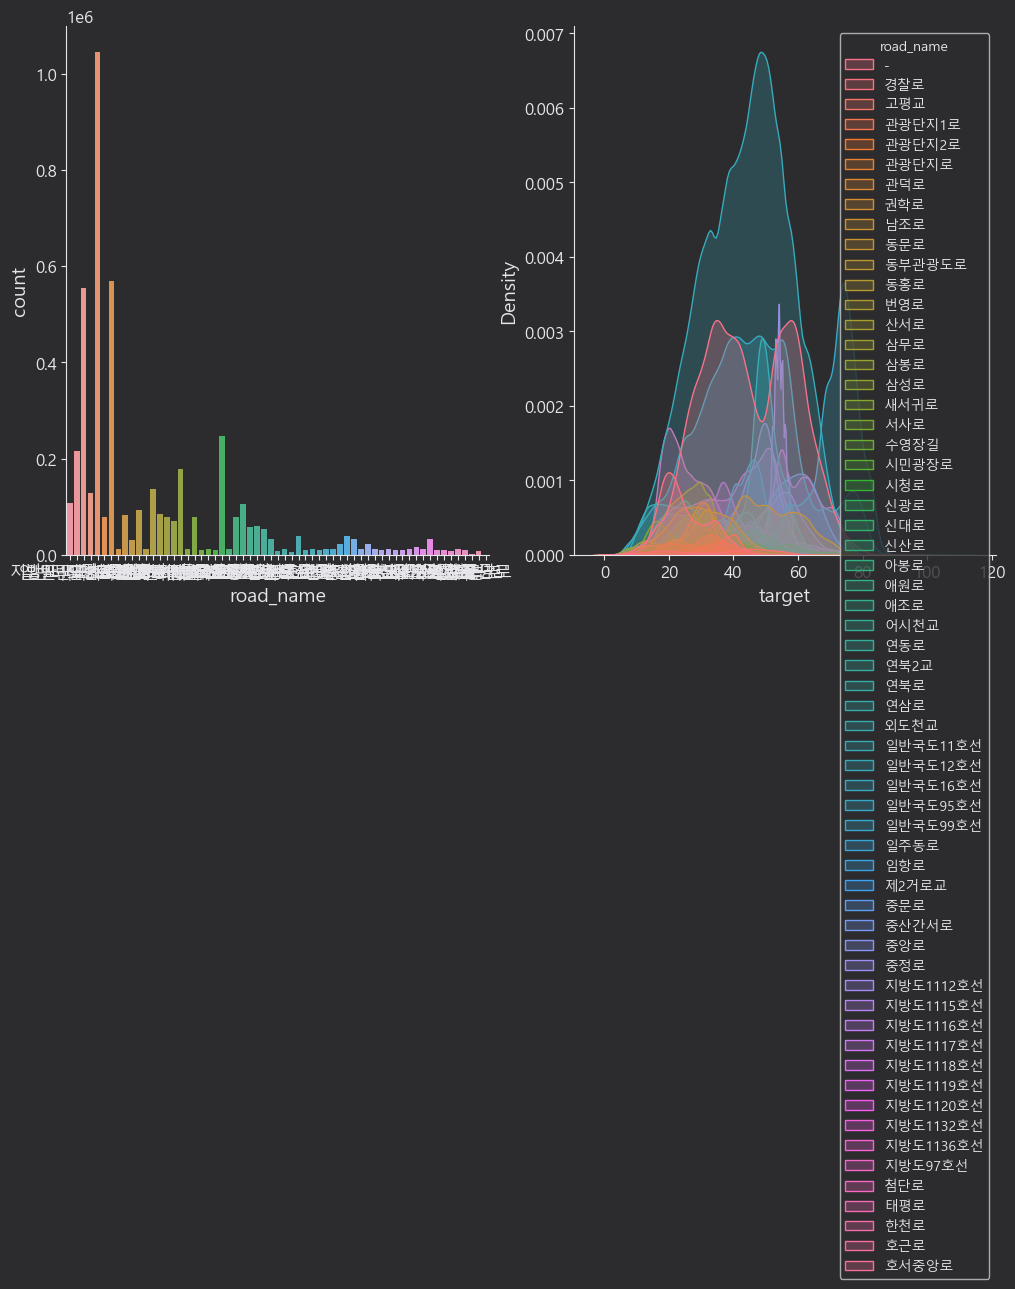

In [ ]:
# 도로명
obj_plot("road_name")

0.0        4032874
43200.0     410361
32400.0     239305
50000.0      18677
Name: weight_restricted, dtype: int64


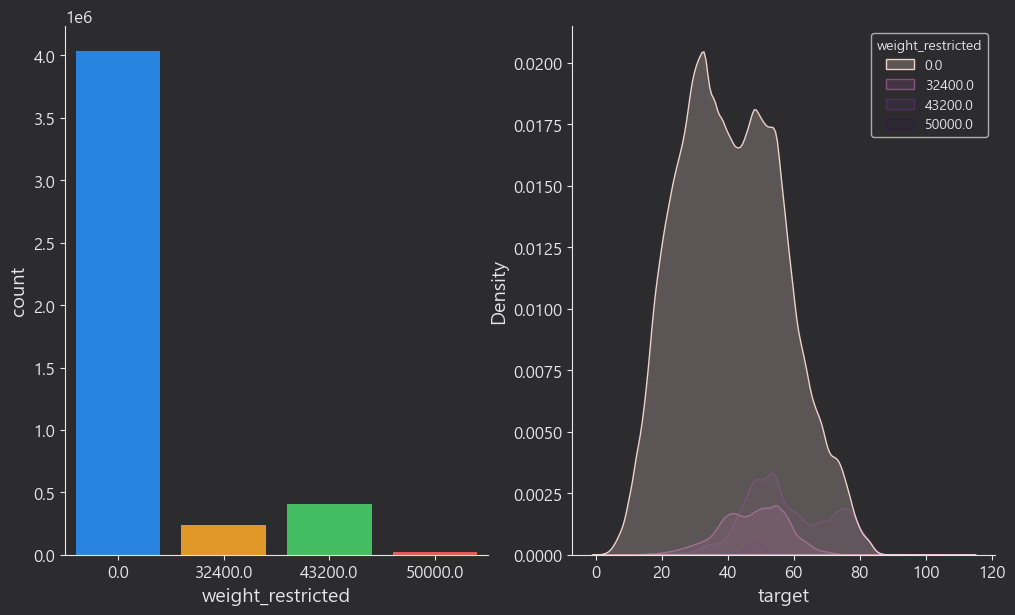

In [ ]:
obj_plot("weight_restricted")

없음    4239701
있음     461516
Name: start_turn_restricted, dtype: int64


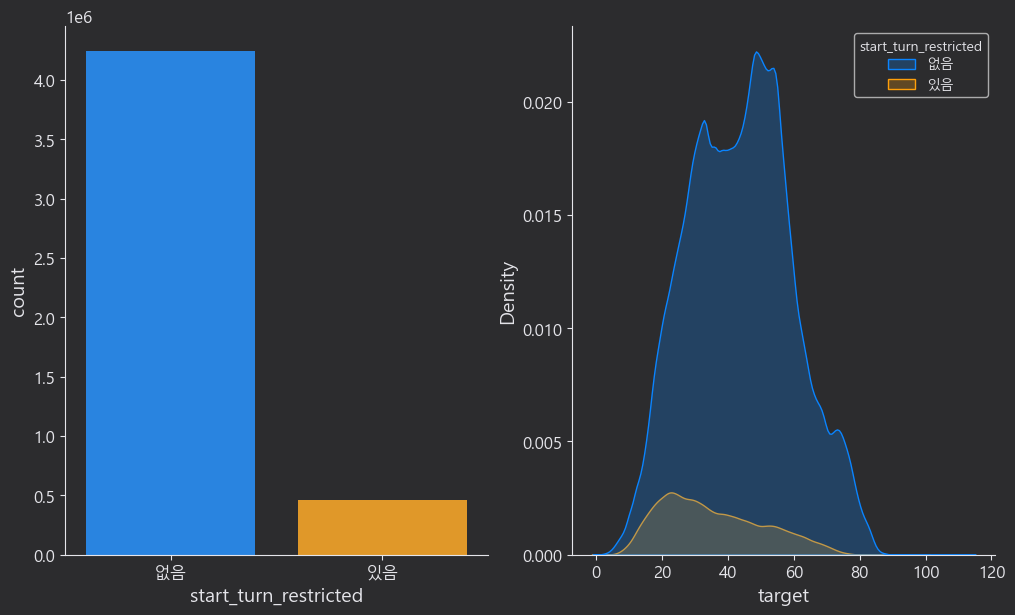

In [ ]:
obj_plot("start_turn_restricted")

103    2159511
107    1582214
106     959492
Name: road_rating, dtype: int64


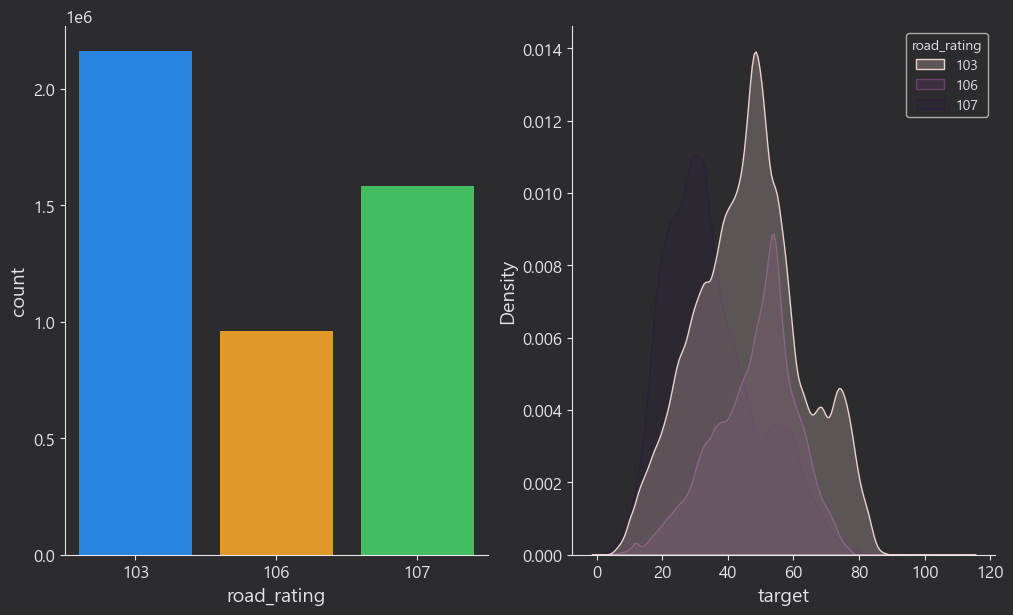

In [ ]:
obj_plot("road_rating")

24


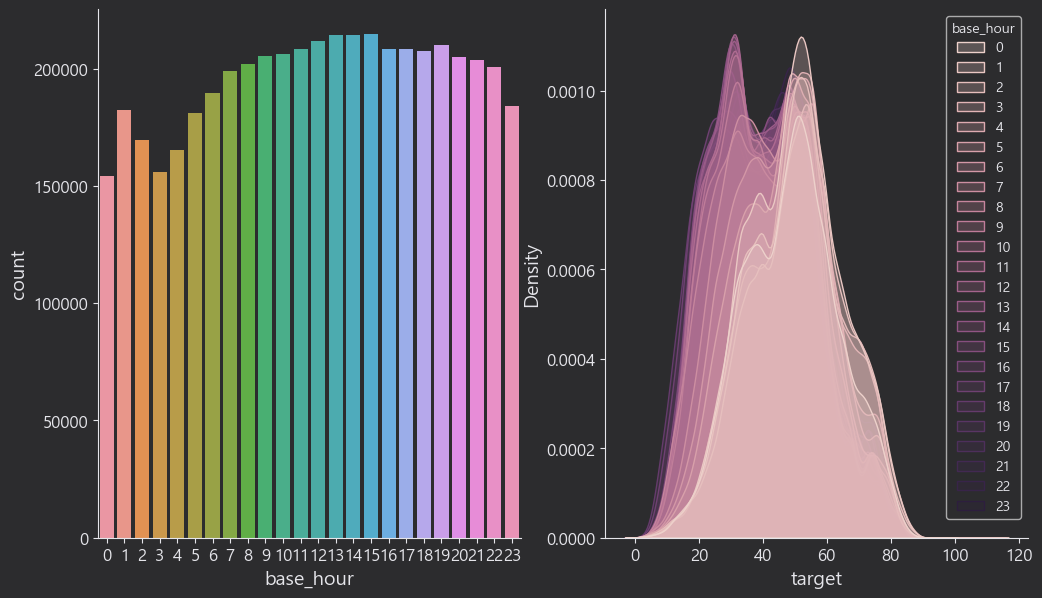

In [ ]:
obj_plot("base_hour")

2    2352092
1    1558531
3     790594
Name: lane_count, dtype: int64


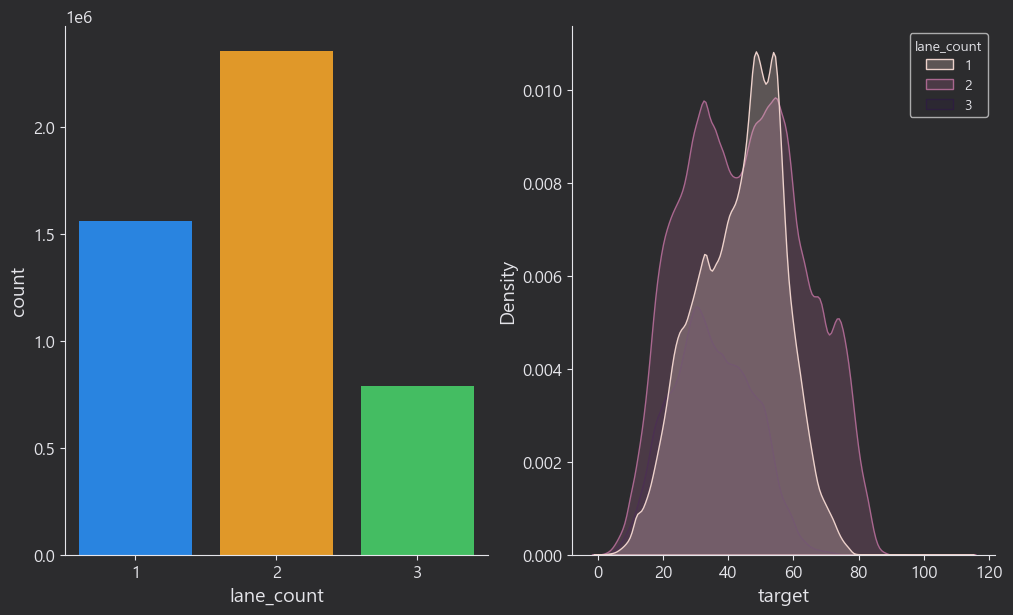

In [ ]:
obj_plot("lane_count")

0    4698978
1       2239
Name: multi_linked, dtype: int64


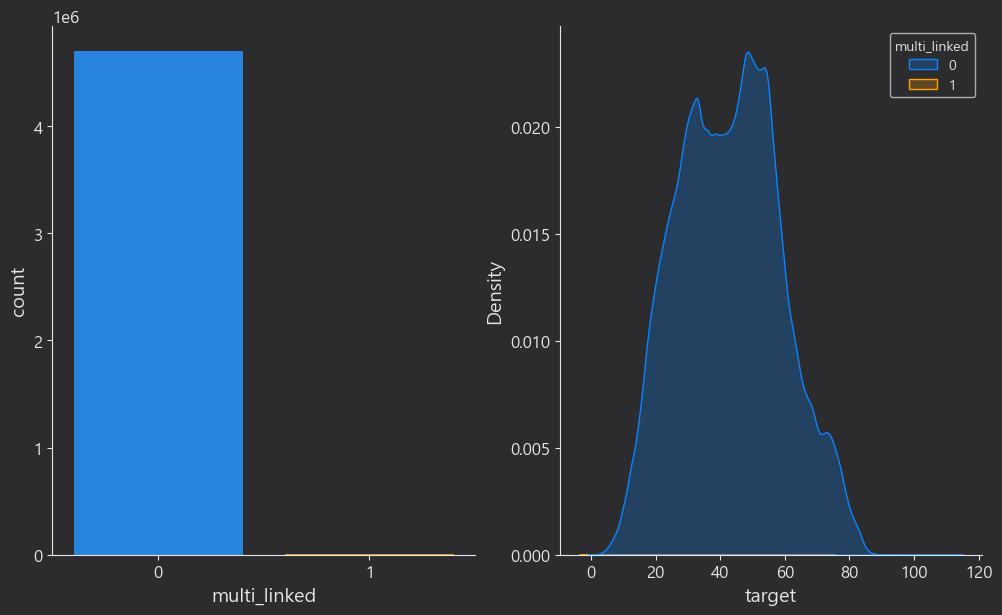

In [ ]:
obj_plot("multi_linked")

0      4689075
103      12142
Name: connect_code, dtype: int64


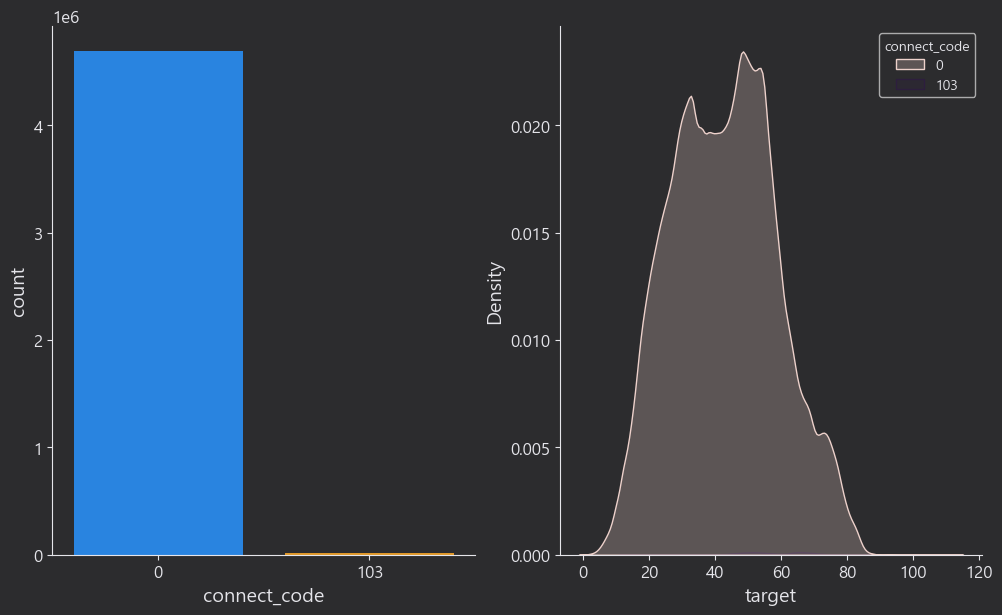

In [ ]:
obj_plot("connect_code")

60.0    1665573
50.0    1103682
70.0     995077
80.0     700334
30.0     229761
40.0       6790
Name: maximum_speed_limit, dtype: int64


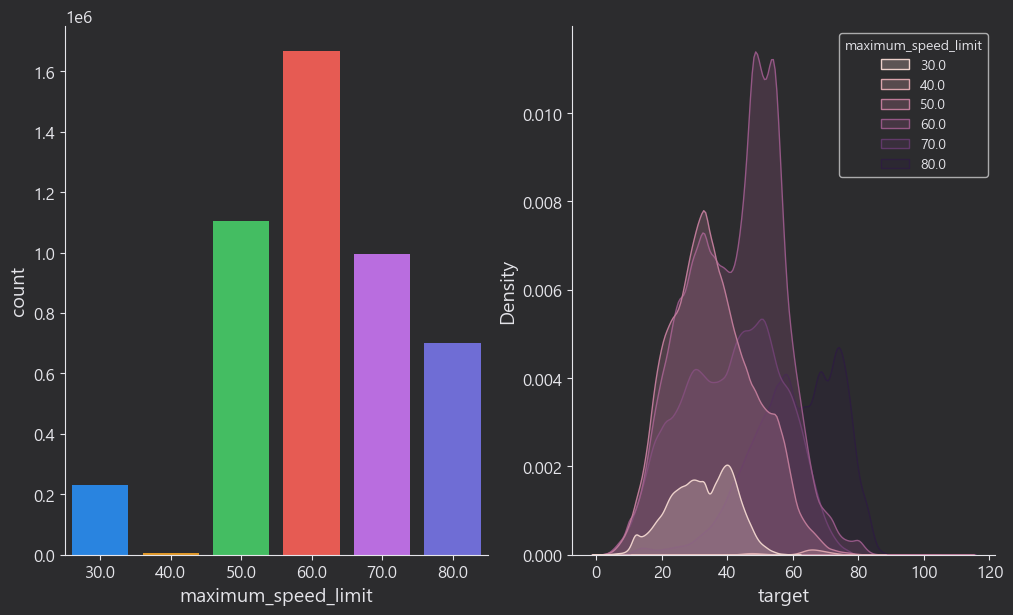

In [ ]:
obj_plot("maximum_speed_limit")

없음    4239599
있음     461618
Name: end_turn_restricted, dtype: int64


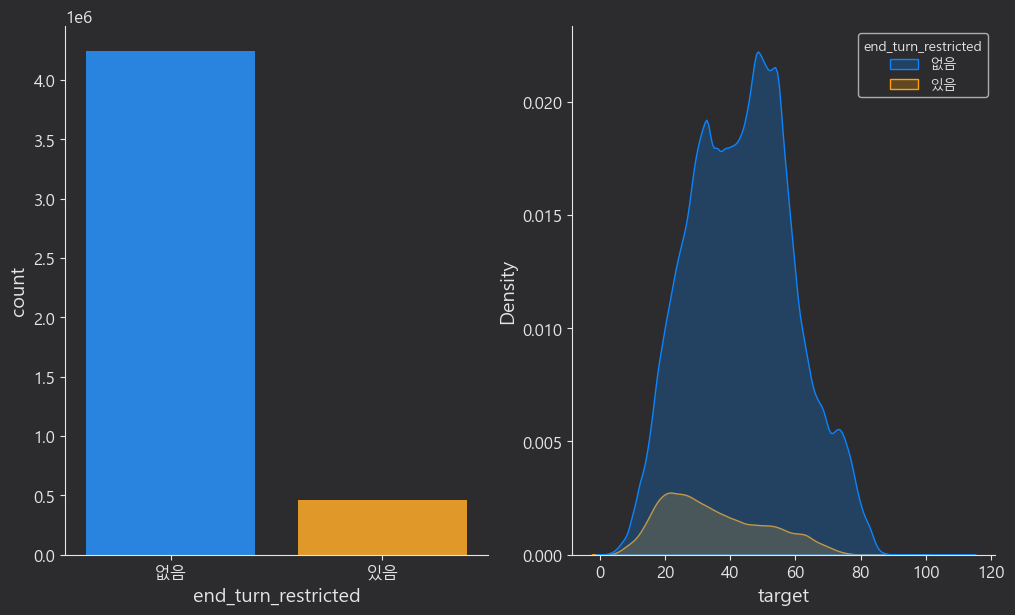

In [ ]:
obj_plot("end_turn_restricted")

586


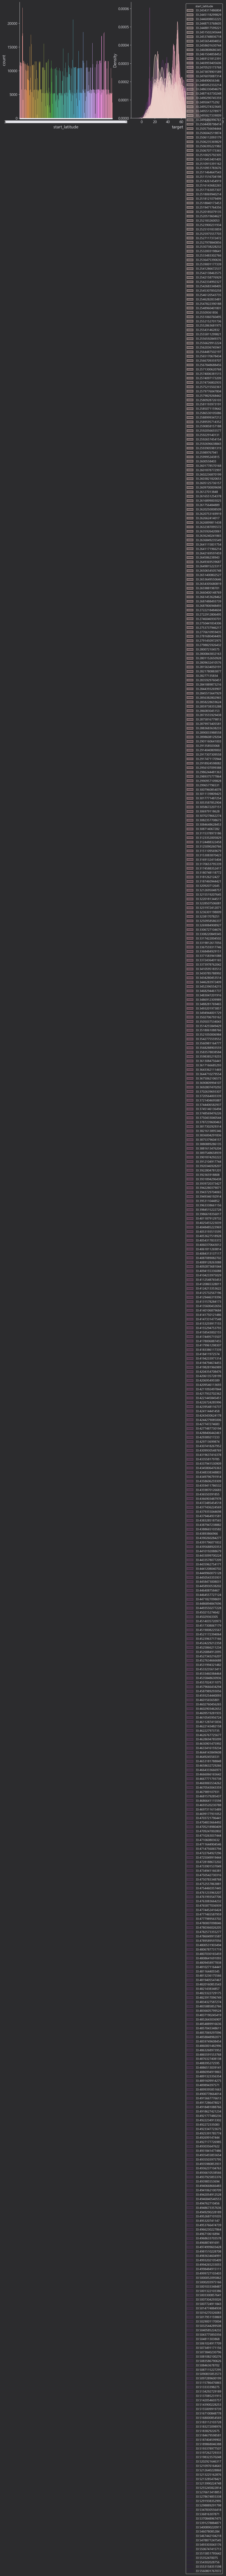

In [ ]:
obj_plot("start_latitude")

0    3737117
3     964100
Name: road_type, dtype: int64


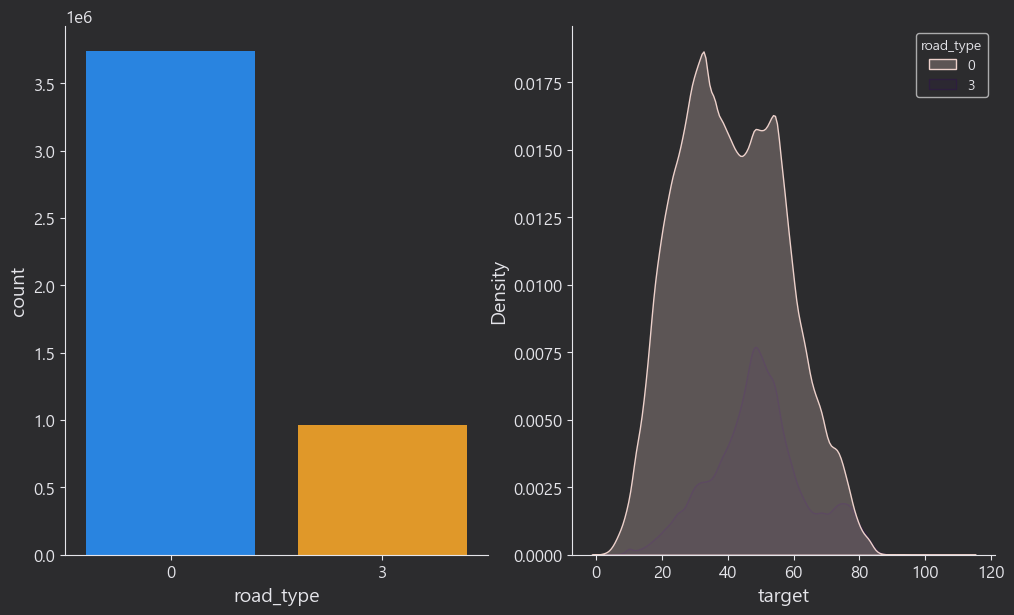

In [ ]:
obj_plot("road_type")

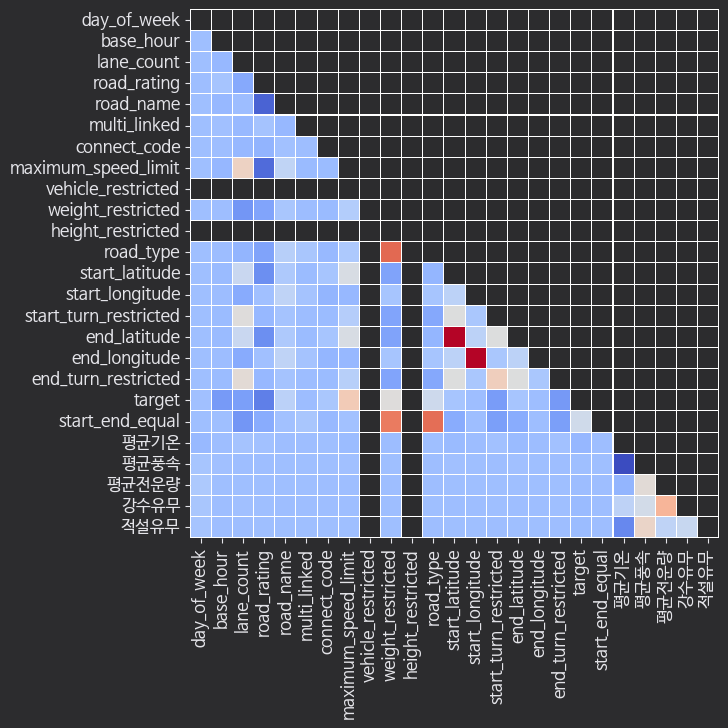

In [ ]:
# 변수 간 상관관계 확인
plt.figure(figsize=(15,7))
mask = np.zeros_like(train_set.corr())
mask[np.triu_indices_from(mask)] = True

sns.heatmap(train_set.corr(), cmap='coolwarm',linewidth=0.05,square=True,cbar=False,mask=mask)